In [1]:
import os
import django
from django.forms.models import model_to_dict

os.chdir('/Users/lavenderca/genomics_network/')
curr_dir = os.getcwd()

django.setup()

In [2]:
from django.contrib.auth.models import User

user = User.objects.all()[0]

In [3]:
from network import models
from analysis import correlation

#### Clean house

In [ ]:
models.Dataset.objects.all().delete()
models.MetaPlot.objects.all().delete()
models.IntersectionValues.objects.all().delete()

In [ ]:
import csv

with open('notebooks/2016-11-01_metaplot_metadata.csv') as metadata:
    reader = csv.DictReader(metadata, delimiter=',')
    for r in reader:
        
        url = 'http://snpinfo.niehs.nih.gov/ucscview/andy/personal_files/' + r['bigWig']
        name = r['name']
        data_type = r['data_type']
        cell_type = r['cell_type']
        antibody = r['antibody']
        
        promoter_bed = curr_dir + '/data/genomic_regions/mm9_RefSeq_promoters.bed'
        enhancer_bed = curr_dir + '/data/genomic_regions/mm9_vista_enhancers.bed'
        
        promoter_gr = models.GenomicRegions.objects.filter(name__startswith='mm9_RefSeq_promoters')[0]
        enhancer_gr = models.GenomicRegions.objects.filter(name__startswith='mm9_RefSeq_enhancers')[0]
        
        promoter_intersection = curr_dir + '/data/intersections/' + r['header'] + '.promoters.intersection.json'
        enhancer_intersection = curr_dir + '/data/intersections/' + r['header'] + '.enhancers.intersection.json'
        
        promoter_metaplot = curr_dir + '/data/metaplots/' + r['header'] + '.promoters.metaplot.json'
        enhancer_metaplot = curr_dir + '/data/metaplots/' + r['header'] + '.enhancers.metaplot.json'
        
        promoter_metaplot_obj = models.MetaPlot.objects.create(
                genomic_regions = promoter_gr,
                bigwig_url = url,
                relative_start = -2500,
                relative_end = 2499,
                meta_plot = promoter_metaplot,
            )
        enhancer_metaplot_obj = models.MetaPlot.objects.create(
                genomic_regions = enhancer_gr,
                bigwig_url = url,
                relative_start = -2500,
                relative_end = 2499,
                meta_plot = enhancer_metaplot,
            )

        promoter_intersection_obj = models.IntersectionValues.objects.create(
                genomic_regions = promoter_gr,
                bigwig_url = url,
                relative_start = -2500,
                relative_end = 2499,
                intersection_values = promoter_intersection,
            )
        enhancer_intersection_obj = models.IntersectionValues.objects.create(
                genomic_regions = enhancer_gr,
                bigwig_url = url,
                relative_start = -2500,
                relative_end = 2499,
                intersection_values = enhancer_intersection,
            )

        models.Dataset.objects.create(
            data_type = data_type,
            cell_type = cell_type,
            antibody = antibody,
            ambiguous_url = url,
            name = name,
            slug = name,
            promoter_intersection = promoter_intersection_obj,
            enhancer_intersection = enhancer_intersection_obj,
            promoter_metaplot = promoter_metaplot_obj,
            enhancer_metaplot = enhancer_metaplot_obj,
        )

In [ ]:
models.CorrelationCell.objects.all().delete()

In [ ]:
all_datasets = models.Dataset.objects.all()

for i, d1 in enumerate(all_datasets):
    for d2 in all_datasets[i+1:]:
        if d1.promoter_intersection.genomic_regions.pk == \
                d2.promoter_intersection.genomic_regions.pk:
                
            intersection_1 = d1.promoter_intersection.intersection_values
            intersection_2 = d2.promoter_intersection.intersection_values
            gr_pk = d1.promoter_intersection.genomic_regions.pk
            gr = models.GenomicRegions.objects.get(pk=gr_pk)

            corr = correlation.Correlation(intersection_1, intersection_2)
            score = abs(corr.get_correlation()[0])
            
            models.CorrelationCell.objects.create(
                x_dataset = d1,
                y_dataset = d2,
                genomic_regions = gr,
                score = score,
            )
            
        
        if d1.enhancer_intersection.genomic_regions.pk == \
                d2.enhancer_intersection.genomic_regions.pk:
                
            intersection_1 = d1.enhancer_intersection.intersection_values
            intersection_2 = d2.enhancer_intersection.intersection_values
            gr_pk = d1.enhancer_intersection.genomic_regions.pk
            gr = models.GenomicRegions.objects.get(pk=gr_pk)

            corr = correlation.Correlation(intersection_1, intersection_2)
            score = abs(corr.get_correlation()[0])
            
            models.CorrelationCell.objects.create(
                x_dataset = d1,
                y_dataset = d2,
                genomic_regions = gr,
                score = score,
            )

In [ ]:
models.CorrelationCell.objects.all()[0].score

hg19_RefSeq_promoters
0
mm9_RefSeq_promoters
2701
hg19_RefSeq_enhancers
0
mm9_RefSeq_enhancers
2701


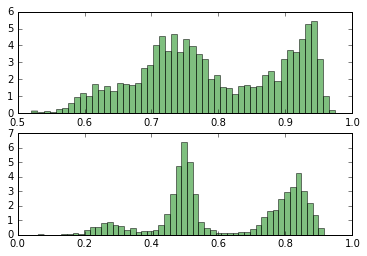

In [10]:
%matplotlib inline
import numpy
import matplotlib.pyplot as plt

count = 1

for gr in models.GenomicRegions.objects.all():
    scores = []
    x = None
    
    print(gr.name)
    print(len(models.CorrelationCell.objects.filter(genomic_regions=gr)))
    for corr in models.CorrelationCell.objects.filter(genomic_regions=gr):
        scores.append(corr.score)
        x = numpy.array(scores)
    
    if x is not None:
        plt.subplot(2, 1, count)
        plt.hist(x, 50, normed=1, facecolor='green', alpha=0.5)
    #     plt.show()
        count += 1